Import modules ＆ packages

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import dataset

###### 讀取訓練數據

In [96]:
train_df = pd.read_csv("train.csv")

###### 讀取測試數據

In [97]:
test_df = pd.read_csv("test.csv")

observing dataset

###### 複製訓練和測試數據，避免對原始數據進行更改

In [98]:
train_df_1 = train_df.copy()
test_df_1 = test_df.copy()

###### 觀察數據

In [99]:
train_df_1.head()
train_df_1.info()
test_df_1.head()
test_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  

In [100]:
train_df_1.groupby('Transported').mean()
train_df_1['RoomService'].value_counts()

0.0       5577
1.0        117
2.0         79
3.0         61
4.0         47
          ... 
1612.0       1
2598.0       1
632.0        1
378.0        1
745.0        1
Name: RoomService, Length: 1273, dtype: int64

###### 檢查缺漏值狀態

In [101]:
train_df_1.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [102]:
len(train_df_1)
len(train_df_1)/2
train_df_1.isnull().sum() > len(train_df_1)/2

PassengerId     False
HomePlanet      False
CryoSleep       False
Cabin           False
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
Name            False
Transported     False
dtype: bool

###### 觀察結果：好像不適合直接 drop 特徵

###### 發現 Cryosleep 缺漏值最多

<Axes: title={'center': 'CryoSleep'}>

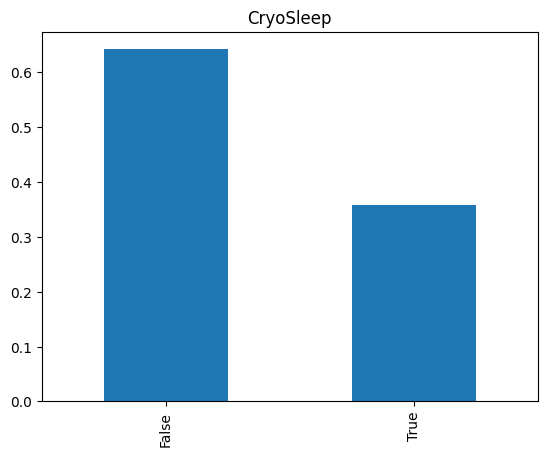

In [103]:
train_df_1['CryoSleep'].value_counts(normalize = True).plot.bar(title = 'CryoSleep')
plt.subplot()

###### 觀察結果：約三到四成的乘客使用 CryoSleep

###### 計算每個 CryoSleep 分組中被傳送的乘客數以及其占該分組總乘客數的百分比

<Axes: xlabel='CryoSleep', ylabel='TransportedPercentage'>

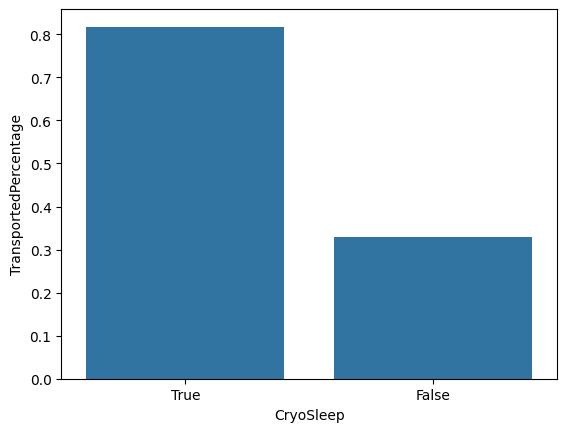

In [104]:
CryoSleep_Transported = train_df_1.groupby('CryoSleep').aggregate({'Transported': 'sum','PassengerId': 'size'}).reset_index()

CryoSleep_Transported['Transported'] = train_df_1.groupby('CryoSleep')['Transported'].sum().reset_index()['Transported']

CryoSleep_Transported['TransportedPercentage'] = CryoSleep_Transported['Transported'] / CryoSleep_Transported['PassengerId']

sns.barplot(x = "CryoSleep", y = "TransportedPercentage", data = CryoSleep_Transported, order = CryoSleep_Transported.sort_values('TransportedPercentage', ascending = False).CryoSleep)
plt.subplot()

###### CryoSleep 中約八成的乘客被傳送

###### 想知道 Cryosleep & 使用 Spaceship 設施費用的相關性

###### 創建 "總花費" 特徵 

In [105]:
train_df_1["TotalSpendings"] = train_df_1["FoodCourt"] + train_df_1["ShoppingMall"] + train_df_1["RoomService"] + train_df_1["Spa"] + train_df_1["VRDeck"]

###### CryoSleep vs. TotalSpendings

(-600.0, 10000.0)

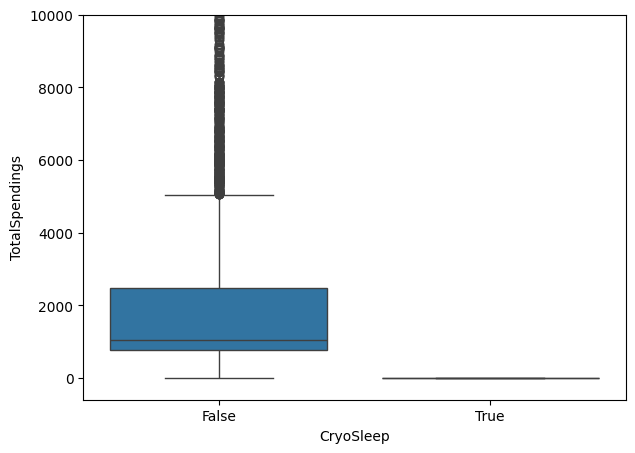

In [106]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = train_df_1, x = "CryoSleep", y = "TotalSpendings")
plt.ylim([-600, 10000])

###### 觀察結果：CryoSleep=True 的乘客的總支出為 0

###### 複製 train_df_1 數據，避免對原始數據進行更改

In [107]:
train_df_2 = train_df_1.copy()

###### 刪除在觀察數據集期間創建的特徵

In [108]:
train_df_2 = train_df_2.drop(["TotalSpendings"], axis = 1)

###### 將目標變數（要預測的變量）從訓練數據集中保存到一個單獨的變數中

In [109]:
target = train_df_2["Transported"]

###### 將測試數據集的乘客ID保存在名為 test_id 的變數中

In [110]:
test_id = test_df_1["PassengerId"]

###### 從訓練集中刪除 'Transported' 變數

In [111]:
train_df_3 = train_df_2.drop(["Transported"], axis = 1)

###### 將訓練集和測試集合併在一起，以便統一進行數據清理

###### 將 train_df_3 和 test_df 沿著垂直方向（垂直堆疊），結合成一個新的 dataframe，然後重新設定索引。

In [112]:
data = pd.concat([train_df_3, test_df], axis = 0).reset_index(drop = True)

###### 查看每個欄位中缺漏值的百分比，用來評估數據集中各個欄位的數據完整性

In [113]:
percentage_missing = (data.isna().sum() / data.shape[0] * 100).round(3)
percentage_missing

PassengerId     0.000
HomePlanet      2.221
CryoSleep       2.390
Cabin           2.305
Destination     2.113
Age             2.082
VIP             2.282
RoomService     2.028
FoodCourt       2.228
ShoppingMall    2.359
Spa             2.190
VRDeck          2.066
Name            2.267
dtype: float64

Fill missing values

###### 複製 data 數據，避免對原始數據進行更改

In [114]:
data_1 = data.copy()

###### 在 data_1 中獲取具有缺漏值的分類列

In [115]:
list_missing_cat_columns = list((data_1.select_dtypes(['object', 'category']).isna().sum() > 0).index)
list_missing_cat_columns

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

###### 使用眾數（出現頻率最高的值）填充數據中的分類列

In [116]:
for col in list_missing_cat_columns:
    mode_value = data_1[col].mode()[0]
    data_1[col] = data_1[col].fillna(mode_value)

###### 填充數值列中的缺漏值，通常可以使用平均值、中位數或其他統計量來填補缺漏值

###### 在 data_1 中獲取具有缺漏值的數值列

In [117]:
list_missing_numeric_col = list((data_1.select_dtypes(np.number).isna().sum() > 0).index)
list_missing_numeric_col

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

###### 發現年齡低於或等於 12 歲的乘客的 Spaceship 設施費用為 0

###### 根據 Age 和是否處於 Cryosleep 的狀態來填補缺漏值

###### ＊np.where(（條件A）|（條件B）,替換值1, 替換值2)。它表示需滿足 條件A 或者 條件B，滿足時條件為真。當條件為真時，替換為替換值1，否則替換為替換值2

In [118]:
def cryosleep_and_age(df):
    
    df["RoomService"] = np.where((df["CryoSleep"] == True) | (df["Age"] < 13), 0, df["RoomService"])
    df["FoodCourt"] = np.where((df["CryoSleep"] == True) | (df["Age"] < 13), 0, df["FoodCourt"])
    df["ShoppingMall"] = np.where((df["CryoSleep"] == True) | (df["Age"] < 13), 0, df["ShoppingMall"])
    df["Spa"] = np.where((df["CryoSleep"] == True) | (df["Age"] < 13), 0, df["Spa"])
    df["VRDeck"] = np.where((df["CryoSleep"] == True) | (df["Age"] < 13), 0, df["VRDeck"])
    
    return df

data_1 = cryosleep_and_age(data_1)

###### 使用平均值填充訓練集中的數值列

In [119]:
for col in list_missing_numeric_col:
    mean_value = data_1[col].mean()
    data_1[col] = data_1[col].fillna(mean_value)
    
data_1.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

###### 新增其他可能影響目標變數的特徵

###### 1. Deck的位置
###### 2. 花費相關
###### 3. 是否獨旅
###### 4. 家庭成員數量

In [120]:
def other_features(df):
    
    # Spaceship層級。 分割 Cabin(deck/num/side)，並獲取第一部分(索引為0)
    df["CabinDeck"] = df["Cabin"].str.split('/', expand=True)[0]
    df["DeckPosition"] = np.where(df["CabinDeck"].isin(['A', 'B', 'C', 'D']), "Lower", "Higher")
    # Spaceship左舷/右舷。 分割 Cabin(deck/num/side)，並獲取第三部分(索引為2)
    df["CabinSide"] = df["Cabin"].str.split('/', expand=True)[2]
    
    # 總花費
    df["TotalSpendings"] = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
    # 每個Deck的平均花費
    Wealthiness_Deck = df.groupby('CabinDeck').agg(TotalSpendings=('TotalSpendings', 'sum'), PassengerCount=('PassengerId', 'size')).reset_index()
    Wealthiness_Deck['DeckAverageSpent'] = Wealthiness_Deck['TotalSpendings'] / Wealthiness_Deck['PassengerCount']
    # 將計算結果合併回原本的dataframe
    df = df.merge(Wealthiness_Deck[["CabinDeck", "DeckAverageSpent"]], how='left', on=['CabinDeck'])
    
    # 團體/獨自旅行。 每個ID均採用形式gggg_pp，其中gggg指示乘客隨行的團體，並且pp是他們在團體中的編號。群體中的人通常是家庭成員，但並非總是如此
    df["PassengerGroup"] = df["PassengerId"].str.split('_', expand=True)[0]
    # 計算每個團體的乘客數量
    df["NoInPassengerGroup"] = df.groupby('PassengerGroup')['PassengerId'].transform('size')
    # 創建 IsAlone 特徵
    df["IsAlone"] = np.where(df["NoInPassengerGroup"] > 1, "Not Alone", "Alone")
    
    # 家庭關係/大小。 分割Name，並獲取第二部分(索引為1)
    df["FamilyName"] = df["Name"].str.split(' ', expand=True)[1]
    # 計算每個家庭的乘客數量
    NoRelatives = df.groupby('FamilyName')['PassengerId'].count().reset_index().rename(columns={"PassengerId": "NoRelatives"})
    # 將計算結果合併回原本的dataframe
    df = df.merge(NoRelatives[["FamilyName", "NoRelatives"]], how='left', on=['FamilyName'])
    # 根據每個家庭的乘客數量，將家庭分為不同的類別
    df["FamilySizeCat"] = pd.cut(df.NoRelatives, bins=[0, 2, 5, 10, 300], labels=['0 - 2', '3 - 5', '6 - 10', '11 - 208'])

    return df

data_2 = other_features(data_1.copy())

###### 刪除一些對模型預測目標不重要或不相關的特徵

In [121]:
data_3 = data_2.copy()
irrelevant_columns = ["Cabin", "PassengerId", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Name", "FamilyName", "PassengerGroup"]
data_3 = data_3.drop(irrelevant_columns, axis = 1)

data_3.shape

(12970, 14)

###### 類別型數據進行獨熱編碼，生成新的虛擬變數（dummy variables）

###### 類別編碼：將類別型變數轉換為模型可以理解的數值型格式。  *ChatGPT 推薦用 獨熱編碼（One-Hot Encoding）：每個類別都被表示為一個二進制向量，其中只有一個元素是1，其他元素都是0

######      舉例來說，假設有一個類別型變數"顏色"，有三個可能的取值："紅色"、"藍色"、"綠色"。進行獨熱編碼後，可能的變換："紅色" 可以表示為 [1, 0, 0]、"藍色" 可以表示為 [0, 1, 0]、"綠色" 可以表示為 [0, 0, 1]

In [122]:
data_3 = pd.get_dummies(data_3, columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinSide', 'IsAlone'])

###### 有序編碼：標籤編碼。 

###### 對有順序關係的三個列 CabinDeck、DeckPosition 和 FamilySizeCat 進行標籤編碼

In [123]:
from sklearn.preprocessing import LabelEncoder

# 初始化 LabelEncoder
label_encoder = LabelEncoder()

# 對指定列進行標籤編碼
for col in ['CabinDeck', 'DeckPosition', 'FamilySizeCat']:
    data_3[col] = label_encoder.fit_transform(data_3[col])

###### 將資料再次分割，獲取訓練數據和測試數據（test 要 4277 筆數據）。

In [124]:
# 複製 data_3，得到 data_4
data_4 = data_3.copy()

# 提取訓練數據，從 data_4 中選擇索引值小於等於 train_df 的最大索引值的部分
final_train_data= data_4.loc[:train_df.index.max(), :].copy()

# 提取測試數據，從 data_4 中選擇索引值大於 train_df 的最大索引值的部分
final_test_data = data_4.loc[train_df.index.max() + 1:, :].reset_index(drop = True).copy()


###### 確保正確分割資料

In [125]:
# print shape of final train data
print(final_train_data.shape)

# print shape of final test data
print(final_test_data.shape)

(8693, 22)
(4277, 22)


Prepare training data

In [126]:
X = final_train_data.copy()

###### 將目標變數保存到 y 中

In [127]:
y = target.astype(int)

###### 初始化 Support Vector Machines 模型

In [128]:
from sklearn.svm import SVC
model = SVC()

###### 使用訓練數據進行模型訓練

In [129]:
model.fit(X, y)

SVC()

###### 預測測試數據

In [130]:
predictions = model.predict(final_test_data)
predictions

array([1, 0, 1, ..., 1, 0, 1])

###### 確認繳交格式

In [131]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


###### 方法一：先輸出模型，再輸入然後調整格式

###### 方法二：直接創建 dataframe 抓出需要的 PassengerId 和 Transported（預測結果）

###### *練習輸出模型，但決定直接使用方法二調整格式

###### 輸出模型

In [132]:
import joblib
joblib.dump(model ,'Titanic-LR-20231115.pkl',compress=3)


['Titanic-LR-20231115.pkl']

###### 將預測結果存儲在 dataframe 中

In [133]:
# 創建一個包含預測結果的 dataframe
predict_df = pd.DataFrame({'PassengerId': test_df_1['PassengerId'], 'Transported': predictions})


###### 調整格式：將 0 替換為 False，將 1 替換為 True

In [134]:
predict_df["Transported"] = predict_df["Transported"].replace({1: True, 0: False})

###### dataframe 轉換成 .csv 格式匯出

In [135]:
predict_df.to_csv("titanic_submission.csv", index = False)

###### 在觀察 train.csv 的資料時發現 CryoSleep=True 的多數乘客的總支出為 0（推測因行動遭限制），並且年齡較小的乘客較無消費能力，

###### 同時也想了解各項特徵與 Transported 事件發生是否有關


###### 所以參考了 https://medium.com/codex/how-to-score-80-accuracy-in-kaggles-spaceship-titanic-competition-using-random-forest-classifier-e7d06ce25bad 這篇文章，

###### 經理解後自行練習並加上附註解釋，兩份 hw2 分別使用不同的訓練方法去訓練模型，但使用的特徵不變。